In [1]:
import math, random
import csv, time

import networkx as nx
import numpy as np
from matplotlib import pyplot as plt

<H1> Basic classes

In [2]:
class Stochastic:
    """" Stochastic variable """

    def __init__(self, law=0, location=0, scale=1, shape=0):
        # distribution law
        self.law = law
        # location parameter
        self.location = location
        # scale parameter
        self.scale = scale
        # form parameter
        self.shape = shape

    def value(self):
        """" Returns the generated value """
        if self.law == 0:
            # rectangular distribution
            return random.uniform(self.location, self.location + self.scale)
        elif self.law == 1:
            # normal distribution
            return random.gauss(self.location, self.scale)
        elif self.law == 2:
            # exponential distribution
            r = random.random()
            while r == 0 or r == 1:
                r = random.random()
            return -self.scale * math.log(r)
        else:
            # rectangular distribution by default
            return random.uniform(self.location, self.location + self.scale)


In [3]:
class Link:
    """ Link between the net nodes """

    def __init__(self, out_node=None, in_node=None, weight=0):
        # type: (Node, Node, float) -> Link
        self.out_node = out_node
        self.in_node = in_node
        # link length [km]
        self.weight = weight
    
    def __str__(self):
        return "{} -> {}: {}".format(self.out_node.name, self.in_node.name, self.weight)


In [4]:
class Node:
    """ Node of the transport net """

    def __init__(self, code=0, name='Node'):
        self.code = code
        self.name = 'Node' + str(code) if name is 'Node' else name
        # graph features
        self.out_links = []
        self.in_links = []
        # demand parameters
        self.s_weight = None # stochastic
        # location (coordinates)
        self.x = 0
        self.y = 0
        # type
        self.type = 'notype'
        # the closest intersection (for non-intersection nodes only)
        self.closest_itsc = None
    
    def __str__(self):
        return "{}: [{}, {}], {}".format(self.name, self.x, self.y, self.type)

In [5]:
class Consignment:

    def __init__(self, weight=0, orgn=None, dst=None):
        self.weight = weight # the consignment weight
        self.origin = orgn # node of origin
        self.destination = dst # node of destination
    
    def __str__(self):
        return '{0} -> {1}: {2}'.format(self.origin.code, self.destination.code, self.weight)

In [6]:
class Route:

    def __init__(self, net=None, csts=[]):
        self.consignments = csts
        self.net = net  # net on which the route is defined
        self.sdm = np.array([[]])  # shortest distances matrix
        if net is not None:
            self.sdm = self.net.sdm

    def __repr__(self):
        ans = "Route["
        if self.sender is None:
            ans += "None]{"
        else:
            ans += str(self.sender.code) + "]{"
        if self.size > 0:
            for n in self.nodes[:-1]:
                ans += str(n.code) + "--"
            ans += str(self.nodes[-1].code)
        ans += "}" + "({}): {} km, {} tons, {} tkm".format(self.size,
                                                           round(self.distance, 3),
                                                           round(self.weight, 3),
                                                           round(self.transport_work, 3))
        return ans

    @property
    def size(self):
        return len(self.consignments)

    @property
    def sender(self):
        if self.size == 0 or self.net is None:
            return None
        else:
            # the same sender for all consignments!!!
            return self.consignments[0].origin

    @property
    def nodes(self):
        return [self.sender] + [c.destination for c in self.consignments] + [self.sender]

    @property
    def distance(self):
        if self.size == 0 or self.net is None:
            return None
        else:
            d = 0
            for i in range(1, len(self.nodes)):
                d += self.sdm[self.nodes[i - 1].closest_itsc.code][self.nodes[i].closest_itsc.code]
            return d

    @property
    def transport_work(self):
        if self.size == 0 or self.net is None:
            return None
        else:
            w = 0
            vol = self.weight
            for i in range(1, len(self.nodes) - 1):
                w += self.sdm[self.nodes[i - 1].closest_itsc.code][self.nodes[i].closest_itsc.code] * vol
                vol -= self.consignments[i - 1].weight
            return w

    @property
    def weight(self):
        return sum([c.weight for c in self.consignments])

    @property
    def weights(self):
        return [c.weight for c in self.consignments]

    def merge(self, other):
        if (other is not None) and (self.net is other.net):
            self.consignments += other.consignments

In [7]:
class Net:
    """ Delivery network as the graph model """

    def __init__(self):
        # network model time
        self.time = 0
        # duration of the network simulation [min]
        self.duration = 0
        # network geography
        self.nodes = []
        self.links = []
        # transport demand
        self.demand = []
        # servicing facilities
        self.fleet = []
        self.load_points = []
        # shortest distances od_matrix
        self.sdm = np.array([[]])
        # matrix representation
        self.mtx = np.array([[]])

    def __str__(self):
        res = "The network configuration:\n"
        for lnk in self.links:
            res += "{0} -> {1}: {2}\n".format(lnk.out_node.code,\
                                                lnk.in_node.code,\
                                                round(lnk.weight, 3))
        return res

    def contains_node(self, code):
        """" Determines if the network contains a node with the specified code """
        for n in self.nodes:
            if n.code == code:
                return True
        return False

    def get_node(self, code):
        """" Returns the first found node with the specified code """
        for n in self.nodes:
            if n.code == code:
                return n
        return None
    
    def contains_link(self, out_node, in_node):
        """ Checks if the net contains a link """
        for lnk in self.links:
            if lnk.out_node is out_node and lnk.in_node is in_node:
                return True
        return False

    def get_link(self, out_node, in_node):
        """" Returns the first found link with the specified out and in nodes """
        for lnk in out_node.out_links:
            if lnk.out_node is out_node and lnk.in_node is in_node:
                return lnk
        return None

    def add_link(self, out_code, in_code, weight=0, directed=False):
        """" Adds a link with the specified characteristics """
        if self.contains_node(out_code):
            # out-node is already in the net
            out_node = self.get_node(out_code)
            if self.contains_node(in_code):
                # in-node is already in the net
                in_node = self.get_node(in_code)
                if self.contains_link(out_node, in_node):
                    # out-node and in-node are already linked: change the link weight
                    self.get_link(out_node, in_node).weight = weight
                else:
                    # there is no such a link in the net: add a new one
                    new_link = Link(out_node, in_node, weight)
                    out_node.out_links.append(new_link)
                    in_node.in_links.append(new_link)
                    self.links.append(new_link)
            else:
                # the net contains the specified out-node, but there is no in-node with the specified code
                in_node = Node(in_code)
                new_link = Link(out_node, in_node, weight)
                out_node.out_links.append(new_link)
                in_node.in_links.append(new_link)
                self.nodes.append(in_node)
                self.links.append(new_link)
        else:
            # the net does not contain the specified out-node
            out_node = Node(out_code)
            if self.contains_node(in_code):
                # in-node is already in the net
                in_node = self.get_node(in_code)
            else:
                # there are no in-node and out-node with the specified codes
                in_node = Node(in_code)
                self.nodes.append(in_node)
            # create new link
            new_link = Link(out_node, in_node, weight)
            out_node.out_links.append(new_link)
            in_node.in_links.append(new_link)
            self.nodes.append(out_node)
            self.links.append(new_link)
        # add the reverse link
        if not directed:
            self.add_link(in_code, out_code, weight, True)

    @property
    def to_matrix(self):
        self.nodes.sort(key=lambda nd: nd.code) # sort the nodes!
        mtx = np.array([[np.inf for _ in self.nodes] for __ in self.nodes])
        for nd in self.nodes:
            mtx[nd.code][nd.code] = 0
        for lnk in self.links:
            mtx[lnk.out_node.code][lnk.in_node.code] = lnk.weight
        return mtx

    def floyd_warshall(self, nodes):
        nodes.sort(key=lambda nd: nd.code)
        #print [nd.code for nd in nodes]
        g = np.array([[np.inf for _ in nodes] for __ in nodes])
        for nd in nodes:
            g[nd.code][nd.code] = 0
        for lnk in self.links:
            g[lnk.out_node.code][lnk.in_node.code] = lnk.weight
        for nk in nodes:
            for ni in nodes:
                for nj in nodes:
                    dist = g[ni.code][nk.code] + g[nk.code][nj.code]
                    if g[ni.code][nj.code] > dist:
                        g[ni.code][nj.code] = dist
        return g
    
    def gps_distance(self, node1, node2):
        # Haversine Formula
        res = 0
        if (node1 is not None and node2 is not None):
            lat1, lon1 = node1.x, node1.y
            lat2, lon2 = node2.x, node2.y
            Earth_radius = 6371  # km
            dlat = math.radians(lat2 - lat1)
            dlon = math.radians(lon2 - lon1)
            a = (math.sin(0.5 * dlat) * math.sin(0.5 * dlat) + \
                 math.cos(math.radians(lat1)) * \
                 math.cos(math.radians(lat2)) * \
                 math.sin(0.5 * dlon) * math.sin(0.5 * dlon))
            res = round(2 * Earth_radius * \
                            math.atan2(math.sqrt(a), math.sqrt(1 - a)), 3)
        return res
    
    def gen_requests(self, sender=None, nodes=[], probs={}, s_weight=Stochastic()):
        self.demand = []
        for node in nodes:
            if random.random() < probs[node.type]:
                cst = Consignment()
                cst.origin, cst.destination = sender, node
                cst.weight = s_weight.value()
                self.demand.append(cst)
        print "Demand generation completed: {} requests generated.".format(len(self.demand))

    def dijkstra(self, source):
        size = len(self.nodes)
        distance = [np.inf for _ in range(size)]
        previous = [None for _ in range(size)]
        q = self.nodes[:]
        distance[source.code] = 0
        while len(q) > 0:
            u = q[0]
            min_distance = distance[u.code]
            for nd in q:
                if distance[nd.code] < min_distance:
                    u = nd
                    min_distance = distance[u.code]
            q.remove(u)
            neighbors = [lnk.in_node for lnk in u.out_links]
            for v in neighbors:
                alt = distance[u.code] + self.get_link(u, v).weight
                if alt < distance[v.code]:
                    distance[v.code] = alt
                    previous[v.code] = u
        return previous

    def define_path(self, source, target):
        previous = self.dijkstra(source)
        u = target
        path = []
        while previous[u.code] is not None:
            path.append(u)
            u = previous[u.code]
        path.reverse()
        return path

    def clarke_wright(self, sender_code=0, requests=[], capacity=0.15, verbose=True):
        
        def route_of(nd):
            for rt in routes:
                if nd in rt.nodes:
                    return rt
            return None

        def are_in_same_route(nd1, nd2):
            for rt in routes:
                if nd1 in rt.nodes and nd2 in rt.nodes:
                    return True
            return False

        def is_in_head(nd, rt):
            if rt is None or nd not in rt.nodes:
                return False
            return rt.nodes.index(nd) == 1

        def is_in_tail(nd, rt):
            if rt is None or nd not in rt.nodes:
                return False
            return rt.nodes.index(nd) == rt.size

        def is_head_or_tail(nd):
            rt = route_of(nd)
            return rt is not None and (is_in_head(nd, rt) or is_in_tail(nd, rt))
        
        routes = [] # the calculated routes
        n = len(self.nodes) # number of nodes in the net

        # choose only consignments with sender as origin
        sender = self.get_node(sender_code) # sernder's node
        from_sender = []
        for cst in requests:
            if cst.origin is sender:
                from_sender.append(cst)
        # combine multiple consignments for the same destination
        if verbose: print "Combining multiple consignments..."
        combined_weights = [0 for _ in range(n)]
        for cst in from_sender:
            combined_weights[cst.destination.code] += cst.weight
        combined = [] # set of consignments combined by consignees
        consignee_codes = []
        for i in range(n):
            if combined_weights[i] > 0:
                combined.append(Consignment(combined_weights[i],
                                            sender, self.get_node(i)))
                consignee_codes.append(i)
        if verbose: print sender_code, consignee_codes
        # number of consignees
        m = len(consignee_codes)
        
        itsc_code = lambda code: self.get_node(consignee_codes[code]).closest_itsc.code

        # get SDM for the routing problem
        d = np.array([[np.inf for _ in range(m + 1)]
                      for __ in range(m + 1)])
        d[0][0] = self.sdm[sender_code][sender_code]
        for i in range(1, m + 1):
            d[0][i] = self.sdm[sender_code][itsc_code(i - 1)]
            d[i][0] = self.sdm[itsc_code(i - 1)][sender_code]
            for j in range(1, m + 1):
                d[i][j] = self.sdm[itsc_code(i - 1)][itsc_code(j - 1)]
        if verbose:
            print "\nSDM for the routing problem:"
            print d

        if verbose: print "\nClarke-Wright algorithm started..."

        # forming the set of simple routes (pendular with empty returns)
        for cst in combined:
            rt = Route(self, [cst])
            routes.append(rt)
        # calculating the wins matrix
        if verbose: print "\nCalculating the wins matrix..."
        start_time = time.time()
        s = np.array([[0.0 for _ in range(m)]
                      for __ in range(m)]) # wins matrix
        for i in range(m):
            for j in range(m):
                if j < i:
                    s[i][j] = d[0][i] + d[0][j] - d[i][j]
                else:
                    s[i][j] = -np.inf
        if verbose:
            print "\nWins matrix for the routing problem (calculated in {} sec):".format(time.time() - start_time)
            print s
            print "\nForming the routes..."
        start_time = time.time()
        # start the routes merging
        while True:
            max_s = -np.inf
            i_max, j_max = 0, 0
            for i in range(m):
                for j in range(m):
                    if s[i][j] > max_s:
                        max_s = s[i][j]
                        i_max, j_max = i, j
            s[i_max][j_max] = -np.inf
            nd1, nd2 = self.get_node(itsc_code(i_max)), self.get_node(itsc_code(j_max))
            r1 = route_of(nd1)
            r2 = route_of(nd2)
            # conditions to be fulfilled for segments merging
            if not are_in_same_route(nd1, nd2) and \
                is_head_or_tail(nd1) and is_head_or_tail(nd2) and \
                r1.weight + r2.weight <= capacity:
                # checking the side before merging
                if r1.size > 1:
                    if is_in_tail(nd1, r1):
                        if r2.size > 1 and is_in_tail(nd2, r2):
                            r2.nodes.reverse()
                        r1.merge(r2)
                        routes.remove(r2)
                    else:
                        if r2.size > 1 and is_in_head(nd2, r2):
                            r2.nodes.reverse()
                        r2.merge(r1)
                        routes.remove(r1)
                else:
                    if is_in_tail(nd2, r2):
                        r2.merge(r1)
                        routes.remove(r1)
                    else:
                        r1.merge(r2)
                        routes.remove(r2)
            # checking if the optimization procedure is complete
            if max_s == -np.inf:
                break
        # printing the routes to console
        if verbose:
            print "{} routes were formed in {} sec.".format(len(routes), time.time() - start_time)
            for rt in routes:
                print rt
        # return the list of routes
        return routes

    @property
    def od_matrix(self):
        od = {}
        for origin in self.nodes:
            for destination in self.nodes:
                od[(origin.code, destination.code)] = 0
        for cst in self.demand:
            od[(cst.origin.code, cst.destination.code)] += 1
        return od

    def print_odm(self):
        od = self.od_matrix
        print "O/D\t",
        for nd in self.nodes:
            print "{0}\t".format(nd.code),
        print
        for origin in self.nodes:
            print "{0}\t".format(origin.code),
            for destination in self.nodes:
                print "{0}\t".format(od[(origin.code, destination.code)]),
            print

    def print_sdm(self):
        print "SDM\t",
        for nd in self.nodes:
            print nd.code, "\t",
        print
        for i in range(len(self.nodes)):
            print self.nodes[i].code, "\t",
            for j in range(len(self.nodes)):
                print round(self.sdm[i][j], 3), "\t",
            print

    def load_from_file(self, fnodes='nodes.txt', flinks='links.txt', dlm='\t'):
        # load nodes
        nodes = []
        f = open(fnodes, 'r')
        for data_line in f:
            data = data_line.split(dlm)
            node = Node(code=int(data[0]), name=data[1])
            node.type = data[2].strip()
            node.x, node.y = float(data[3]), float(data[4])
            self.nodes.append(node)
            if node.type == 'N' or node.type == 'L':
                nodes.append(node)
        f.close()
        self.set_regions()
        self.nodes.sort(key=lambda nd: nd.code)
        # load links
        f = open(flinks, 'r')
        for data_line in f:
            data = data_line.split(dlm)
            code1, code2 = int(data[1]), int(data[2])
            dist = 0
            if self.contains_node(code1) and self.contains_node(code2):
                dist = self.gps_distance(self.get_node(code1), self.get_node(code2))
            self.add_link(code1, code2, dist)
        f.close()
        # set iternal variables
        self.mtx = self.to_matrix
        self.sdm = self.floyd_warshall(nodes)

    def set_regions(self):
        itscs = [node for node in self.nodes if node.type == 'N']
        for node in self.nodes:
            closest, dist = node, float('inf')
            if not node in itscs:
                for itsc in itscs:
                    d = self.gps_distance(node, itsc)
                    if d < dist:
                        dist = d
                        closest = itsc
            node.closest_itsc = closest

<H1> Run simulations

In [10]:
net = Net()
net.load_from_file(fnodes='nodes_s.txt', flinks='links_s.txt')

In [8]:
# net = Net()
# net.load_from_file(fnodes='nodes_s.txt', flinks='links_s.txt')
probs = {'R': 0.2, 'H': 0.05, 'S': 0.2, 'P': 0.15, 'W': 0.05}
s_weight=Stochastic(law=1, location=0.05, scale=0.01)
nodes = [node for node in net.nodes if node.type != 'N' and node.type != 'L']
lpoints = [node for node in net.nodes if node.type == 'L']
#
sender = lpoints[1] # 0-4
#
net.gen_requests(sender=sender, nodes=nodes, probs=probs, s_weight=s_weight)
routes = net.clarke_wright(sender_code=sender.code, requests=net.demand, capacity=0.15, verbose=False)
total_tkm = sum(route.transport_work for route in routes)
print total_tkm

Demand generation completed: 127 requests generated.
3.390862924457324


<H1>Visualisation

In [11]:
nodes = net.nodes

min_x, max_x = 100, 0
min_y, max_y = 100, 0

for nd in nodes:
    if nd.x < min_x: min_x = nd.x
    if nd.y < min_y: min_y = nd.y
    if nd.x > max_x: max_x = nd.x
    if nd.y > max_y: max_y = nd.y

print min_x, max_x, min_y, max_y
# normalize coordinates
for nd in nodes:
    nd.x = (nd.x - min_x) / (max_x - min_x)
    nd.y = (nd.y - min_y) / (max_y - min_y)

50.05435 50.06554 19.9326 19.94416


1034


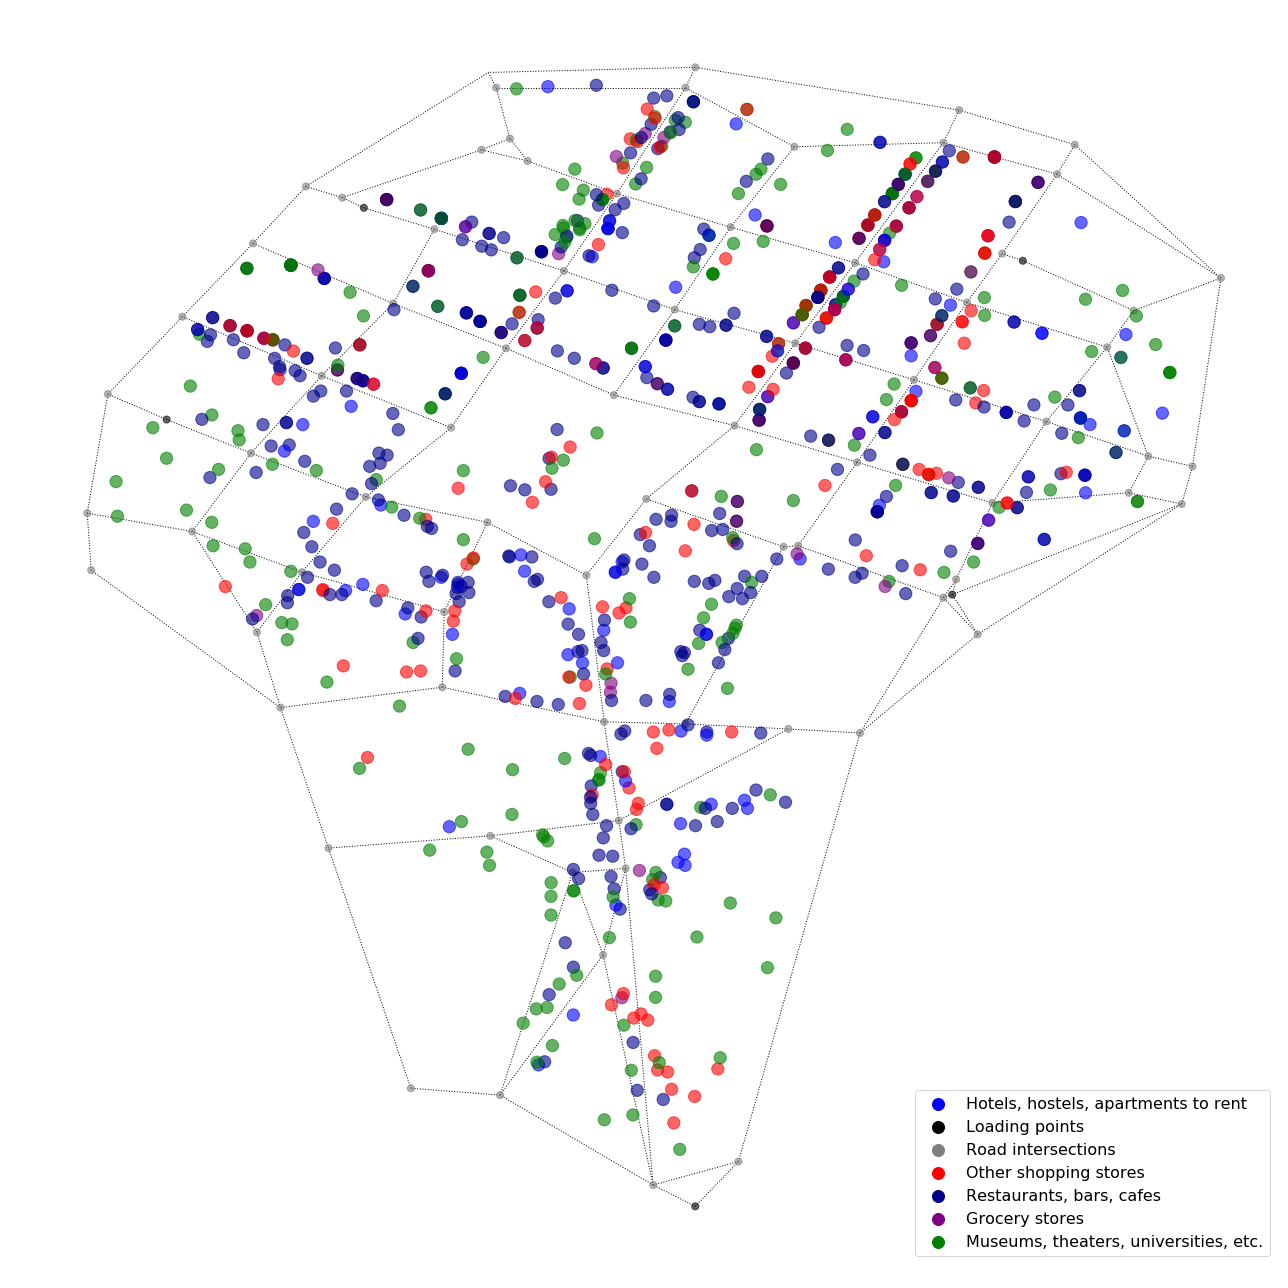

In [12]:
G = nx.Graph()
for nd in nodes:
    G.add_node(nd.code, pos=(nd.y, nd.x))
for lnk in net.links:
    G.add_edge(lnk.out_node.code, lnk.in_node.code)

pos = nx.get_node_attributes(G, 'pos')
print len(pos)

color_map = {
    'R': 'darkblue',
    'H': 'blue',
    'S': 'purple',
    'P': 'red',
    'W': 'green',
    'N': 'grey',
    'L': 'black'
}
node_type_name = {
    'R': 'Restaurants, bars, cafes',
    'H': 'Hotels, hostels, apartments to rent',
    'S': 'Grocery stores',
    'P': 'Other shopping stores',
    'W': 'Museums, theaters, universities, etc.',
    'N': 'Road intersections',
    'L': 'Loading points'
}
colors = [color_map.get(nd.type) for nd in nodes]

fig = plt.figure(figsize=(18, 18))

ax = fig.add_subplot(1, 1, 1)
for label in sorted(color_map):
    ax.scatter([], [], color=color_map[label], label=node_type_name[label])

nx.draw_networkx_nodes(G,
                       pos=pos,
                       nodelist=range(79),
                       alpha=0.6,
                       node_color=colors[:80],
                       node_size=50
                      )
nx.draw_networkx_nodes(G,
                       pos=pos,
                       nodelist=range(80, 1034),
                       alpha=0.6,
                       node_color=colors[80:],
                       node_size=150
                      )

nx.draw_networkx_edges(G, 
                       pos=pos,
                       style='dotted')

plt.axis('off')
plt.legend(loc='lower right', fontsize=16, markerscale=2.0)
fig.tight_layout()
plt.savefig("client_map_s.png", dpi=300)
plt.show()

In [ ]:
len(net.nodes), len(colors)

In [ ]:
type_map = {'R': 0, 'H': 0, 'S': 0, 'P': 0, 'W': 0, 'N': 0, 'L': 0}
for nd in nodes:
    type_map[nd.type] += 1
type_map

In [ ]:
sum(type_map.values())